[ADD6379.jpg] GT: ADD6379 | Pred: AO6379 | ❌
[AFR9854.jpg] GT: AFR9854 | Pred: AFR9854 | ✅
[AGC6705.jpg] GT: AGC6705 | Pred: AGC6705 | ✅
[AJE631.jpg] GT: AJE631 | Pred: AJESST | ❌
[AJU4818.JPG] GT: AJU4818 | Pred: AJU4818 | ✅
[AKD9878.jpg] GT: AKD9878 | Pred: AKD9878 | ✅
[AKL8520.jpg] GT: AKL8520 | Pred: AKL8520 | ✅
[AKQ206.jpg] GT: AKQ206 | Pred: AKQ206 | ✅
[AKT5.png] GT: AKT5 | Pred: ATSFF | ❌
[AMC9600.png] GT: AMC9600 | Pred: AMC9600 | ✅
[AML8686.jpg] GT: AML8686 | Pred: AML8686 | ✅
[AMP4147.jpg] GT: AMP4147 | Pred: AMP4147 | ✅
[AMX9173.jpg] GT: AMX9173 | Pred: AMX5173 | ❌
[BEF3368.jpg] GT: BEF3368 | Pred: EEBE4 | ❌
[BGD8255.jpg] GT: BGD8255 | Pred: 260BE | ❌
[BHD6344.png] GT: BHD6344 | Pred: BHD6344 | ✅
[BJA5494.jpg] GT: BJA5494 | Pred: BUA5494 | ❌
[BKJ5013.jpg] GT: BKJ5013 | Pred: BK5013 | ❌
[BLL2943.jpg] GT: BLL2943 | Pred: BLL2943 | ✅
[BLP1728.jpg] GT: BLP1728 | Pred: BLP1728 | ✅
[BLQ3936.jpg] GT: BLQ3936 | Pred: BLO3336 | ❌
[BMJ8875.jpg] GT: BMJ8875 | Pred: BNIG875 | ❌
[BMX7261

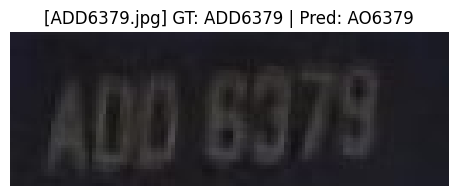

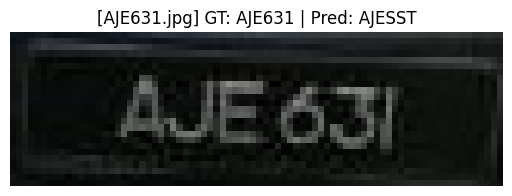

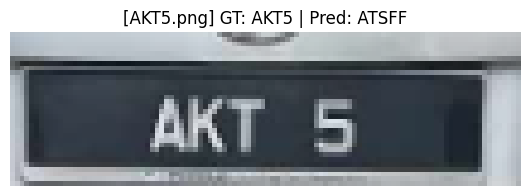

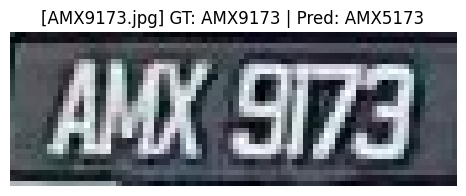

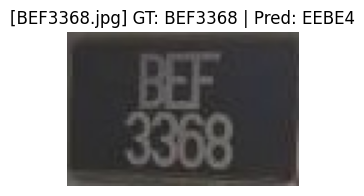

In [11]:
import os
import cv2
import pytesseract
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Set path to Tesseract executable
# Make sure Tesseract-OCR is installed and path is correctly set
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 📁 Dataset base path and subfolders
dataset_path = r"C:\Users\NITRO 5\OneDrive - Swinburne Sarawak\General - COS30018 INTELLIGENT SYSTEMS\Dataset\OCR\Combined"
subfolders = ['train', 'test']

# 🔧 Tesseract OCR configuration
# --oem 1 : Use LSTM OCR engine
# --psm 6 : Assume a single uniform block of text (good for 1-line or 2-line plates)
tess_config = r'--oem 3 --psm 6'

# 📊 Lists to store OCR results and failed samples
results = []
failed_samples = []

def tesseract_original(image_path):
    """
    Run Tesseract OCR on the input image without manual preprocessing.
    
    Args:
        image_path (str): Path to the input image.
    
    Returns:
        tuple: (predicted_text, original_image)
    """
    image = cv2.imread(image_path)
    if image is None:
        return "", None

    # OCR Prediction
    text = pytesseract.image_to_string(image, config=tess_config)

    # Post-processing: remove non-alphanumeric characters, uppercase the text
    text = ''.join(filter(str.isalnum, text)).upper()
    return text, image

# 🔁 Loop through all images in 'train' and 'test' subfolders
for sub in subfolders:
    folder = os.path.join(dataset_path, sub)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder, filename)
            
            # Extract ground truth from filename (assuming filename = ground truth)
            ground_truth = os.path.splitext(filename)[0].upper().replace(" ", "")
            
            # Perform OCR
            predicted_text, raw_image = tesseract_original(image_path)
            
            # Compare prediction with ground truth
            correct = (predicted_text == ground_truth)
            
            # Store the result
            result_entry = {
                "file": filename,
                "folder": sub,
                "ground_truth": ground_truth,
                "predicted": predicted_text,
                "match": correct
            }
            results.append(result_entry)

            # Store failed predictions for later visualization
            if not correct:
                failed_samples.append((result_entry, raw_image))

            # Print prediction result
            print(f"[{filename}] GT: {ground_truth} | Pred: {predicted_text} | ✅" if correct else f"[{filename}] GT: {ground_truth} | Pred: {predicted_text} | ❌")

# 🧮 Calculate and print overall OCR accuracy
total = len(results)
correct = sum(r["match"] for r in results)
accuracy = correct / total * 100
print(f"\n🔍 Total Samples: {total} | Correct: {correct} | Accuracy: {accuracy:.2f}%")

# 💾 Save all OCR results into an Excel file
results_df = pd.DataFrame(results)
output_file = os.path.join(dataset_path, "ocr_results_original_tesseract.xlsx")
results_df.to_excel(output_file, index=False)
print(f"📁 Results saved to: {output_file}")

# 🖼️ Display up to 5 failed predictions
print("\n🔍 Showing up to 5 failed predictions:")
for i, (info, img) in enumerate(failed_samples[:5]):
    plt.figure(figsize=(8, 2))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"[{info['file']}] GT: {info['ground_truth']} | Pred: {info['predicted']}")
    plt.axis("off")
    plt.show()


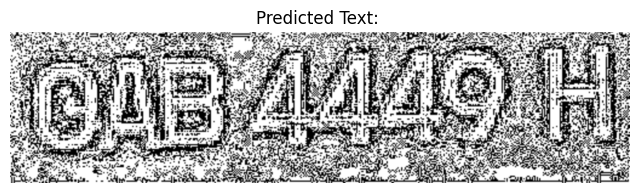

🔍 OCR Prediction: 


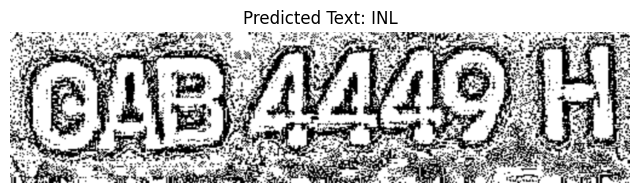

🔍 OCR Prediction: INL
❌ Invalid path. Please try again.
❌ Invalid path. Please try again.


KeyboardInterrupt: Interrupted by user

In [2]:
import os
import cv2
import pytesseract
import matplotlib.pyplot as plt

# 📌 Set path to Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 🔧 Tesseract OCR configuration
tess_config = r'--oem 3 --psm 6'

def tesseract_predict(image_path):
    """
    Run Tesseract OCR on a manually input image.
    
    Args:
        image_path (str): Path to the input image.
    
    Returns:
        str: Predicted text
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Failed to load image: {image_path}")
        return None

    # OCR Prediction
    text = pytesseract.image_to_string(image, config=tess_config)

    # Post-processing: clean the text
    text = ''.join(filter(str.isalnum, text)).upper()

    # Show the image
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 4))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Text: {text}")
    plt.axis("off")
    plt.show()

    return text

# 🚀 Manual input
if __name__ == "__main__":
    while True:
        image_path = input("\n📂 Enter image path (or type 'exit' to quit): ").strip()
        if image_path.lower() == 'exit':
            print("👋 Exiting.")
            break

        if not os.path.isfile(image_path):
            print("❌ Invalid path. Please try again.")
            continue

        predicted_text = tesseract_predict(image_path)
        if predicted_text is not None:
            print(f"🔍 OCR Prediction: {predicted_text}")

